## COVID-19 RADIOGRAPHY BASED CLASSIFICATION USING MULTIPROTOTYPE FUZZY LOGIC
------
#### Batch 1 Grp 2 EDI :
- 12011104 - Tanmay Mutalik
- 12011328 - Vishal Govindani
- 12011078 - Kuhu Mukhopadhyay
- 12011385 - Amey Chopde

------

## About the Dataset:
#### COVID-19 CHEST X-RAY DATABASE:


        - A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19, normal and other lung infection dataset is released in stages. In the first release we have released 219 COVID-19, 1341 normal and 1345 viral pneumonia chest X-ray (CXR) images. In the first update, we have increased the COVID-19 class to 1200 CXR images. In the 2nd update, we have increased the database to 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images and corresponding lung masks. We will continue to update this database as soon as we have new x-ray images for COVID-19 pneumonia patients. 

##### Formats
        - All the images are in Portable Network Graphics (PNG) file format and resolution are 299*299 pixels.

##### Objective
       -  Researchers can use this database to produce useful and impactful scholarly work on COVID-19, which can help in tackling this pandemic.

##### COVID-19 data:
>
>COVID data are collected from different publicly accessible dataset, online sources and published papers.
>- 2473 CXR images are collected from padchest dataset[1].
>- 183 CXR images from a Germany medical school[2].
>- 559 CXR image from SIRM, Github, Kaggle & Tweeter[3,4,5,6]
>- 400 CXR images from another Github source[7].


##### Normal images:
>10192 Normal data are collected from from three different dataset.
>- 8851 RSNA [8]
>- 1341 Kaggle [9]


##### Lung opacity images:
>6012 Lung opacity CXR images are collected from Radiological Society of North America (RSNA) CXR dataset  [8]

##### Viral Pneumonia images:bo
>1345 Viral Pneumonia data are collected from  the Chest X-Ray Images (pneumonia) database [9]

##### Dataset Link:


[COVID-19 Chest X-Ray Database](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database)


## Reference:
[1]https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711

[2]https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png

[3]https://sirm.org/category/senza-categoria/covid-19/

[4]https://eurorad.org

[5]https://github.com/ieee8023/covid-chestxray-dataset

[6]https://figshare.com/articles/COVID-19_Chest_X-Ray_Image_Repository/12580328

[7]https://github.com/armiro/COVID-CXNet  

[8]https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

[9] https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

----

In [199]:
# import the necessary packages
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
# # light background plots
plt.style.use('seaborn-white')

import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import ast
import pywt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# import ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

` Defining Functions for basic image processing ` 

In [2]:
# functions for image processing
#! add contrast to the image 
def contrast(img, alpha, beta):
    new_img = np.zeros(img.shape, img.dtype)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
    return new_img

#! add brightness to the image
def brightness(img, alpha, beta):
    new_img = np.zeros(img.shape, img.dtype)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
    return new_img

#! add gamma to the image
def gamma(img, gamma):
    gamma_table = [np.power(x/255.0, gamma)*255.0 for x in range(256)]
    gamma_table = np.round(np.array(gamma_table)).astype(np.uint8)
    return cv2.LUT(img, gamma_table)

#! add blur to the image
def blur(img, ksize):
    return cv2.blur(img, (ksize, ksize))

#! add sharpen to the image
def sharpen(img, ksize):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(img, -1, kernel)

#! add emboss to the image
def emboss(img, ksize):
    kernel = np.array([[-2,-1,0], [-1,1,1], [0,1,2]])
    return cv2.filter2D(img, -1, kernel)

#! add edge detection to the image
def edge_detection(img, ksize):
    kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
    return cv2.filter2D(img, -1, kernel)

` Defining Functions for file handling ` 

In [3]:
def formatString(string):
    string = string.replace("array([", "[")
    string = string.replace("]),array([", "],[")
    string = string.replace("])", "]")
    return string


def convertToArray(string):
    listArr = ast.literal_eval(string)
    return listArr


def tupleToList(listArr):
    array = []
    for i in range(len(listArr)):
        array.append(listArr[i])
    return array

def loadFile(path):
    with open(path, 'r') as f:
        vector = f.read()
        vector = formatString(vector)
        vector = convertToArray(vector)
        vector = tupleToList(vector)
        f.close()
    return vector

        
def saveFile(path, vector):
    with open(path, 'w') as f:
        f.write(str(vector))
        f.close()

In [4]:

#! function to return a vector of frequency of all intensities from 0 to 255

def get_img_vector(img):
    img_vector = np.zeros(256)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            img_vector[img[i][j]] += 1
    return img_vector


#! function to calculate euclidean distance between two vectors
def euclidean_distance(vector1, vector2):
    try: 
        distance = 0.0
        for i in range(len(vector1)):
            distance += np.square(vector1[i] - vector2[i])
        distance = np.sqrt(distance)
        return distance
    except Exception as e:
        print("Error")
        print(e)
        # print(i,j)
        return 0

#! function to calculate manhattan distance between two vectors
def manhattan_distance(vector1, vector2):
    return np.sum(np.abs(vector1 - vector2))

In [179]:
def assignClass(covid_membership, normal_membership, pneumonia_membership):
    if covid_membership > normal_membership and covid_membership > pneumonia_membership:
        return "covid"

    elif normal_membership > covid_membership and normal_membership > pneumonia_membership:
        return "normal"

    elif pneumonia_membership > normal_membership and pneumonia_membership > covid_membership:
        return "pneumonia"

    elif normal_membership == covid_membership == pneumonia_membership:
        return "\nCovid, Normal, Pneumonia have same membership.Cannot assign a single class"

    elif normal_membership == covid_membership:
        return "\nNormal and Covid have same membership.Cannot assign a single class "

    elif normal_membership == pneumonia_membership:
        return "\nNormal and Pneumonia have same membership.Cannot assign a single class"
    elif covid_membership == pneumonia_membership:
        return "\nPneumonia and Covid have same membership.Cannot assign a single class"
    else:
        return "\n Some error occurred"


def accuracy(lengthTestVectors, lengthCorrectlyClassified):
    return (lengthCorrectlyClassified/lengthTestVectors)*100


def getDegreeOfMembership(distance, gamma):

    temp = gamma * distance

    if(temp > 1):
        return 0
    elif(temp == 0):
        return 1
    else:
        return 1-temp


def getMaximumMembership(test_vector, prototypes, gamma):
    maxDegree = getDegreeOfMembership(
        euclidean_distance(test_vector, prototypes[0]), gamma)
    index = 0

    for i in range(1, len(prototypes)):
        degree = getDegreeOfMembership(
            euclidean_distance(test_vector, prototypes[i]), gamma)
        if degree > maxDegree:
            maxDegree = degree
            index = i
    return index, maxDegree


----

### Defining a process to check the validity of input image

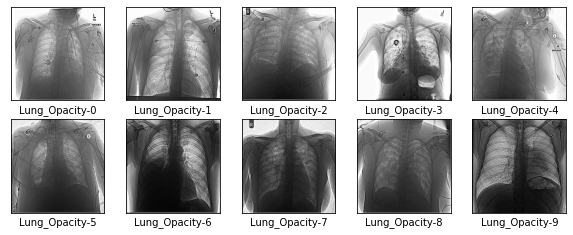

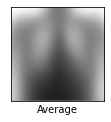

In [7]:
# read sharpen images from the folder sharpen_images of lung_opacity
lung_opacity_sharpen_length =len(os.listdir('../COVID-19_Radiography_Dataset/Lung_Opacity/sharpen_images/'))
lung_opacity_sharpen = []

for i in range(1, lung_opacity_sharpen_length):
    img = cv2.imread('../COVID-19_Radiography_Dataset/Lung_Opacity/sharpen_images/Lung_Opacity-'+str(i)+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lung_opacity_sharpen.append(img)

# display the 10 sharpen images
plt.figure(figsize=(10,10))
for i in range(0, 10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(lung_opacity_sharpen[i], cmap=plt.cm.binary)
    plt.xlabel('Lung_Opacity-'+str(i))
plt.show()

# get the average image
lung_opacity_average = np.mean(lung_opacity_sharpen, axis=0)

# display the average image
plt.figure(figsize=(10,10))
plt.subplot(5,5,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(lung_opacity_average, cmap=plt.cm.binary)
plt.xlabel('Average')
plt.show()


In [8]:
def is_lung_image(img):
    std = np.std(img)
    std_average = np.std(lung_opacity_average)
    # check if the input image is similar to the average image
    if std > std_average:
        return True
    else:
        return False

----

## Load the Images

` Normal Lungs Images `
    
` Pneumonia Lungs Images `

` COVID Lungs Images `


In [9]:

covid_images_length = len(os.listdir('../COVID-19_Radiography_Dataset/COVID/sharpen_images/'))
normal_images_length = len(os.listdir('../COVID-19_Radiography_Dataset/Normal/sharpen_images/'))
viral_pneumonia_images_length = len(os.listdir('../COVID-19_Radiography_Dataset/Viral Pneumonia/sharpen_images/'))

#! read all images of normal
normal_images = []
for i in range(1, normal_images_length+1):
    normal_images.append(cv2.imread(
        '../COVID-19_Radiography_Dataset/Normal/sharpen_images/Normal-'+str(i)+'.png'))

#! read all images of viral pneumonia
viral_pneumonia_images = []
for i in range(1, viral_pneumonia_images_length+1):
    viral_pneumonia_images.append(cv2.imread(
        '../COVID-19_Radiography_Dataset/Viral Pneumonia/sharpen_images/Viral Pneumonia-'+str(i)+'.png'))

#! read all images of covid
covid_images = []
for i in range(1, covid_images_length+1):
    covid_images.append(cv2.imread(
        '../COVID-19_Radiography_Dataset/COVID/sharpen_images/COVID-'+str(i)+'.png'))

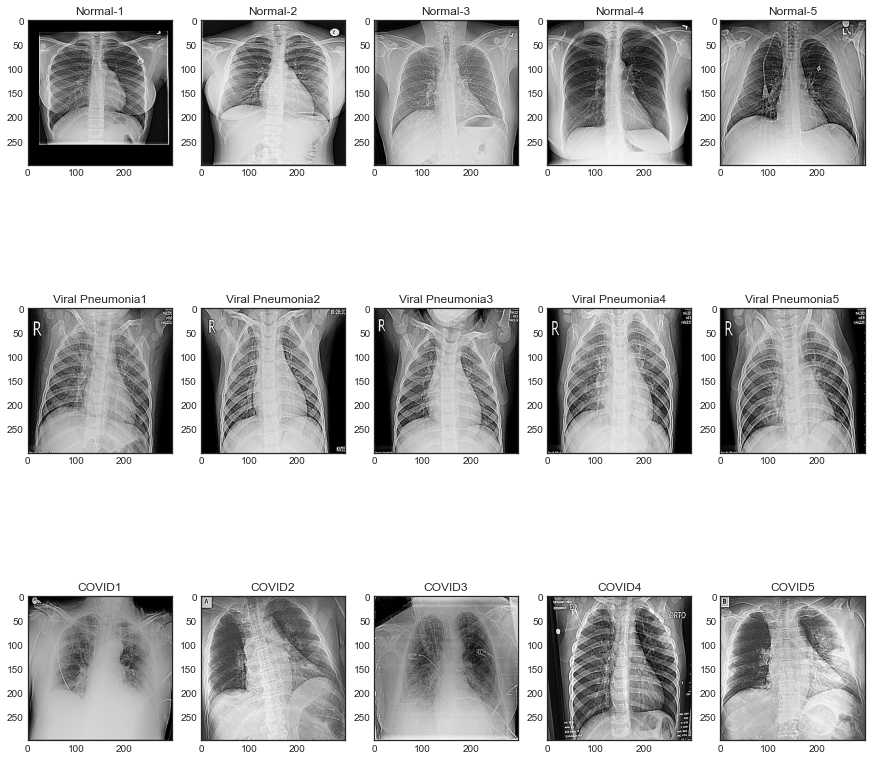

In [165]:

#! Display 5 images from each class with labels with numbers
fig, axs = plt.subplots(3, 5, figsize=(15, 15))
for i in range(5):
    axs[0, i].imshow(normal_images[i])
    axs[0, i].set_title('Normal-'+str(i+1))
    axs[1, i].imshow(viral_pneumonia_images[i])
    axs[1, i].set_title('Viral Pneumonia'+str(i+1))
    axs[2, i].imshow(covid_images[i])
    axs[2, i].set_title('COVID'+str(i+1))
plt.show()

In [11]:
#! get vector of all images of normal
normal_images_vector = loadFile('../COVID-19_Radiography_Dataset/Normal/normal_images_vector.txt')
#! get vector of all images of covid
covid_images_vector = loadFile('../COVID-19_Radiography_Dataset/COVID/covid_images_vector.txt')
#! get vector of all images of viral pneumonia
pneumonia_images_vector = loadFile('../COVID-19_Radiography_Dataset/Viral Pneumonia/viral_pneumonia_images_vector.txt')

#! print vector of all classes
print("No. of Normal Images Vector: ", len(normal_images_vector))
print("No. of COVID Images Vector: ", len(covid_images_vector))
print("No. of Pneumonia Images Vector: ", len(pneumonia_images_vector))

No. of Normal Images Vector:  10192
No. of COVID Images Vector:  3616
No. of Pneumonia Images Vector:  1345


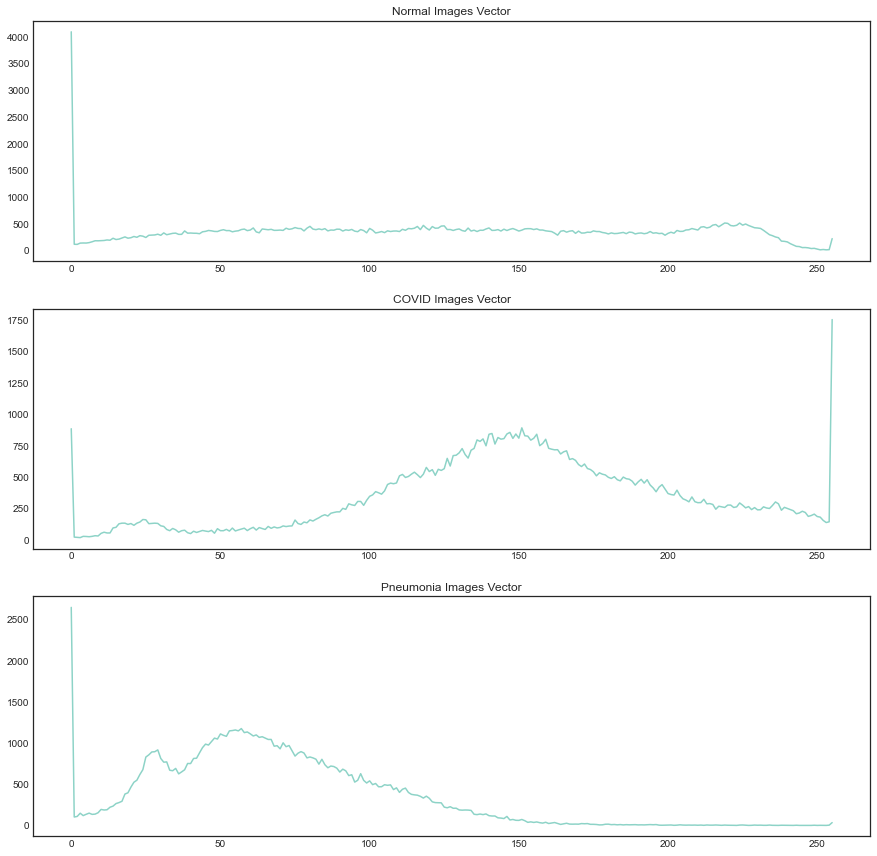

In [166]:

#! histogram of a vector in each class

# add some space between subplots
fig.subplots_adjust(hspace=5)
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(normal_images_vector[11])
axs[0].set_title('Normal Images Vector')
axs[1].plot(covid_images_vector[11])
axs[1].set_title('COVID Images Vector')
axs[2].plot(pneumonia_images_vector[11])
axs[2].set_title('Pneumonia Images Vector')
plt.show()


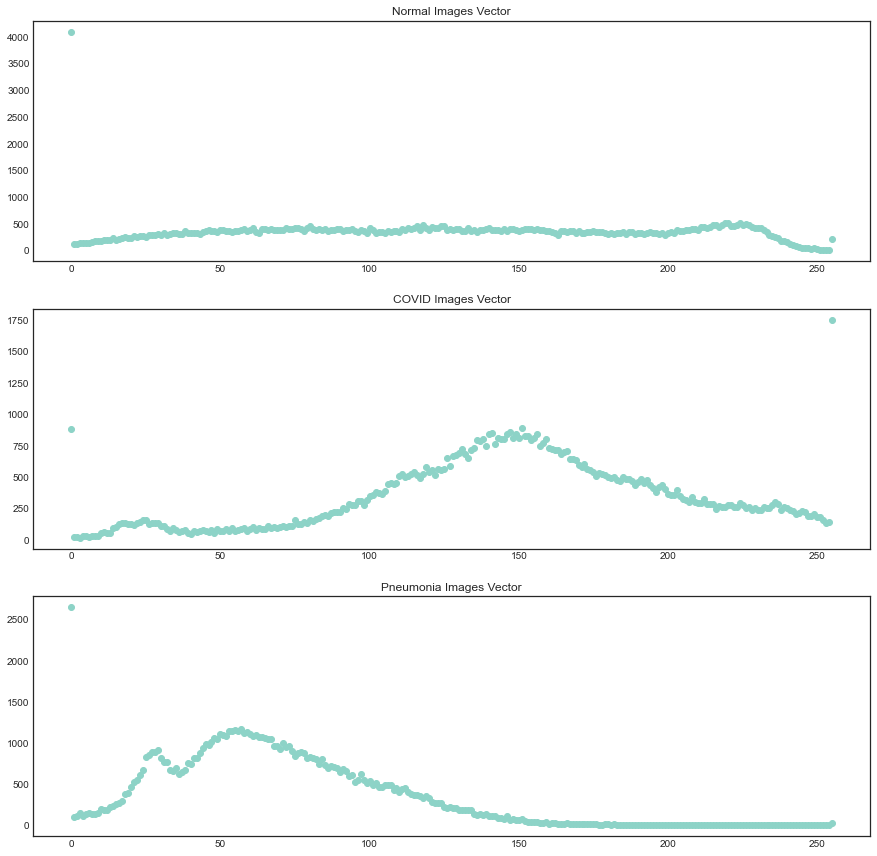

In [167]:

#! display scatter plot a vector in each class
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].scatter(range(256), normal_images_vector[11])
axs[0].set_title('Normal Images Vector')
axs[1].scatter(range(256), covid_images_vector[11])
axs[1].set_title('COVID Images Vector')
axs[2].scatter(range(256), pneumonia_images_vector[11])
axs[2].set_title('Pneumonia Images Vector')
plt.show()

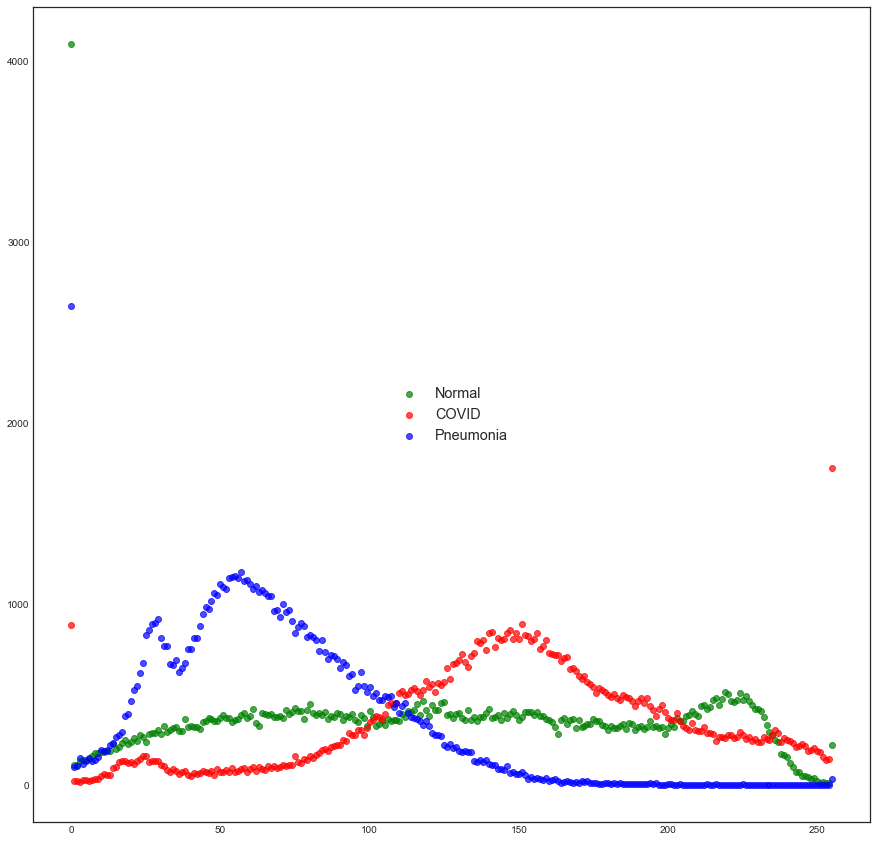

In [168]:
# disply the scatter plot of all classes in same graph
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
axs.scatter(range(256), normal_images_vector[11], alpha=0.7, label='Normal', color='green')
axs.scatter(range(256), covid_images_vector[11], alpha=0.7, label='COVID', color='red')
axs.scatter(range(256), pneumonia_images_vector[11], alpha=0.7, label='Pneumonia', color='blue')
axs.legend(loc='center',shadow=True, fontsize='x-large')
plt.show()


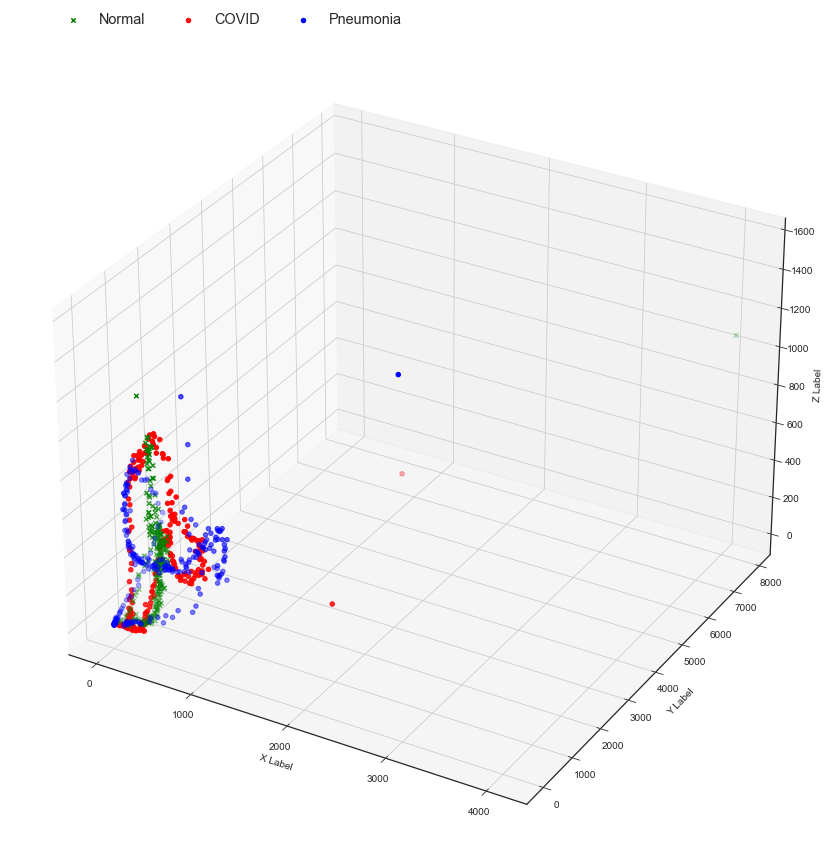

In [170]:
# display the vectors in 3D dimensional space
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(normal_images_vector[11], normal_images_vector[12], normal_images_vector[13], marker="x", label='Normal', color='green')
ax.scatter(covid_images_vector[11], covid_images_vector[12], covid_images_vector[13], marker='o', label='COVID', color='red')
ax.scatter(pneumonia_images_vector[11], pneumonia_images_vector[12], pneumonia_images_vector[13], marker='o', label='Pneumonia', color='blue')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(shadow=True, fontsize='x-large', numpoints=1, bbox_to_anchor=(0.5, 1.05), ncol=3)
plt.show()


    - Divide the data into train and test in the ratio 80:20

    -This division is done in ../divide.ipynb and saved in txt file

    -The txt file is loaded here


In [46]:
normal_train_vectors = loadFile('../COVID-19_Radiography_Dataset/Normal/features//normal_train_vectors.txt')
normal_test_vectors = loadFile('../COVID-19_Radiography_Dataset/Normal/features//normal_test_vectors.txt')
covid_train_vectors = loadFile('../COVID-19_Radiography_Dataset/COVID/features//covid_train_vectors.txt')
covid_test_vectors = loadFile('../COVID-19_Radiography_Dataset/COVID/features//covid_test_vectors.txt')
pneumonia_train_vectors = loadFile('../COVID-19_Radiography_Dataset/Viral Pneumonia/features//pneumonia_train_vectors.txt')
pneumonia_test_vectors = loadFile('../COVID-19_Radiography_Dataset/Viral Pneumonia/features//pneumonia_test_vectors.txt')

#! print vector of all classes
print("No. of Normal Train  Vector: ", len(normal_train_vectors))
print("No. of Normal Test  Vector: ", len(normal_test_vectors))
print("No. of COVID Train  Vector: ", len(covid_train_vectors))
print("No. of COVID Test  Vector: ", len(covid_test_vectors))
print("No. of Pneumonia Train  Vector: ", len(pneumonia_train_vectors))
print("No. of Pneumonia Test  Vector: ", len(pneumonia_test_vectors))




No. of Normal Train  Vector:  8153
No. of Normal Test  Vector:  2039
No. of COVID Train  Vector:  2892
No. of COVID Test  Vector:  724
No. of Pneumonia Train  Vector:  1076
No. of Pneumonia Test  Vector:  269


----

### Vector Normalization
    - In normalization, scaled the vector within the range of the [0,1]
    - dividing the vector with the maximum frequency amongst all the train and test pixel intensities
    - This process is done in ./code.ipynb and saved in txt file
    -Now, loading the normalized vectors

In [ ]:
covid_test_vectors = loadFile('./covid_test_vectors_normalized.txt')
normal_test_vectors = loadFile('./normal_test_vectors_normalized.txt')
pneumonia_test_vectors = loadFile('./pneumonia_test_vectors_normalized.txt')

covid_train_vectors = loadFile('./covid_train_vectors_normalized.txt')
normal_train_vectors = loadFile('./normal_train_vectors_normalized.txt')
pneumonia_train_vectors = loadFile('./pneumonia_train_vectors_normalized.txt')      

In [48]:

#! print vector of all classes
print("No. of Normalized Normal Train  Vector: ", len(normal_train_vectors))
print("No. of Normalized Normal Test  Vector: ", len(normal_test_vectors))
print("No. of Normalized COVID Train  Vector: ", len(covid_train_vectors))
print("No. of Normalized COVID Test  Vector: ", len(covid_test_vectors))
print("No. of Normalized Pneumonia Train  Vector: ", len(pneumonia_train_vectors))
print("No. of Normalized Pneumonia Test  Vector: ", len(pneumonia_test_vectors))


No. of Normalized Normal Train  Vector:  8153
No. of Normalized Normal Test  Vector:  2039
No. of Normalized COVID Train  Vector:  2892
No. of Normalized COVID Test  Vector:  724
No. of Normalized Pneumonia Train  Vector:  1076
No. of Normalized Pneumonia Test  Vector:  269


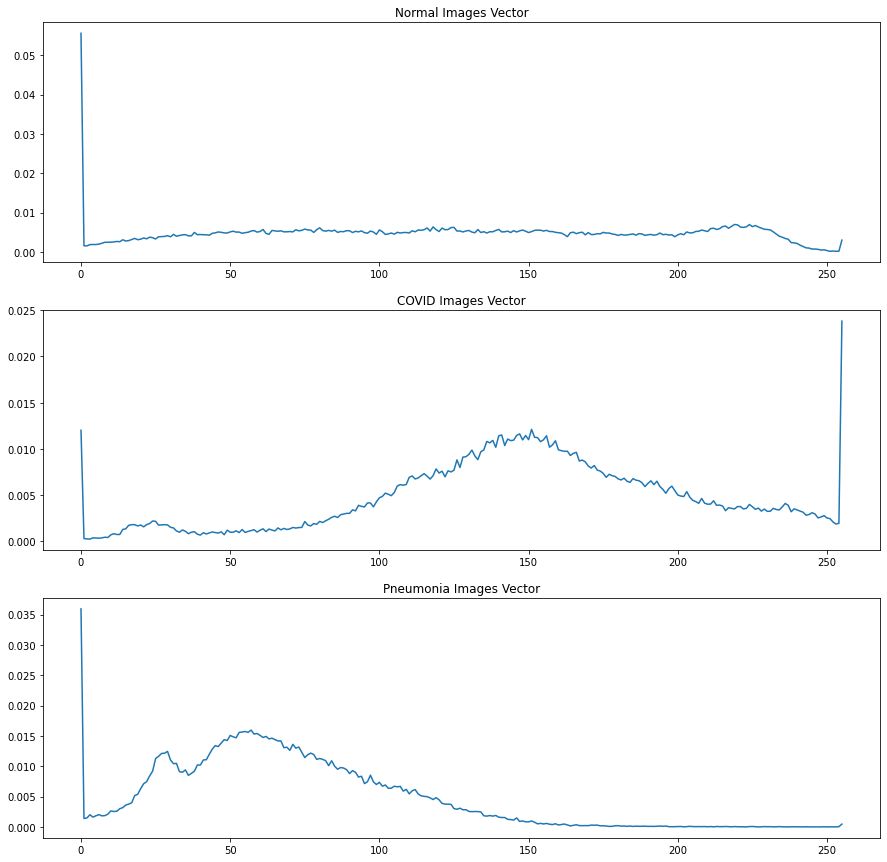

In [49]:

#! histogram of a vector in each class

# add some space between subplots
fig.subplots_adjust(hspace=5)
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(normal_train_vectors[11])
axs[0].set_title('Normal Images Vector')
axs[1].plot(covid_train_vectors[11])
axs[1].set_title('COVID Images Vector')
axs[2].plot(pneumonia_train_vectors[11])
axs[2].set_title('Pneumonia Images Vector')
plt.show()


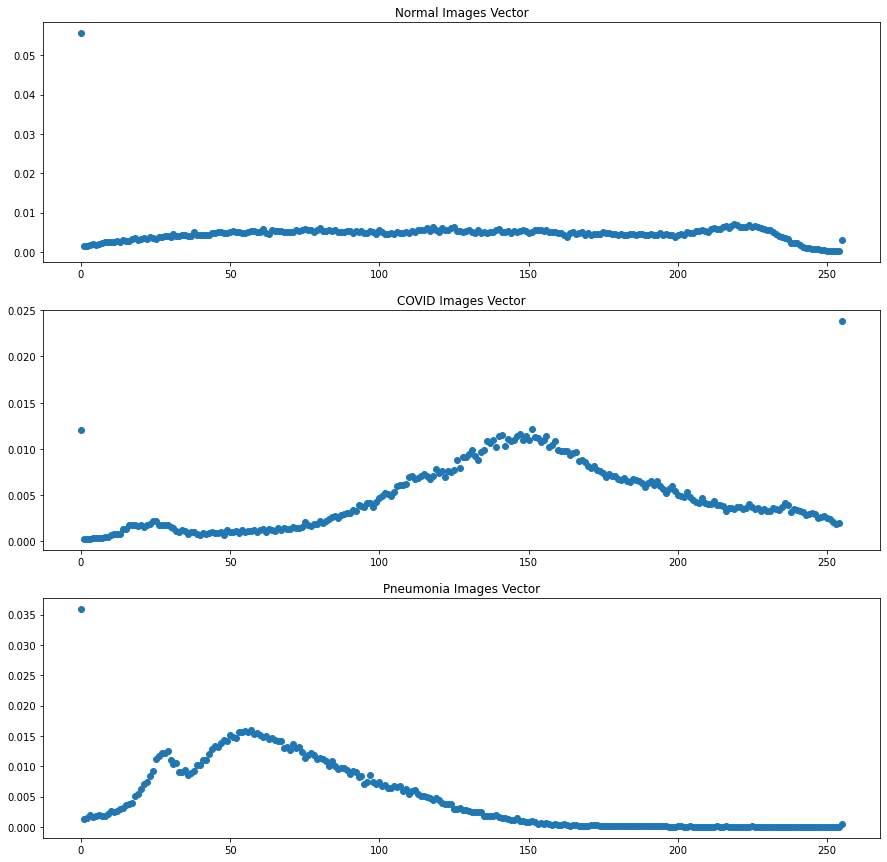

In [50]:

#! display scatter plot a vector in each class
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].scatter(range(256), normal_train_vectors[11])
axs[0].set_title('Normal Images Vector')
axs[1].scatter(range(256), covid_train_vectors[11])
axs[1].set_title('COVID Images Vector')
axs[2].scatter(range(256), pneumonia_train_vectors[11])
axs[2].set_title('Pneumonia Images Vector')
plt.show()



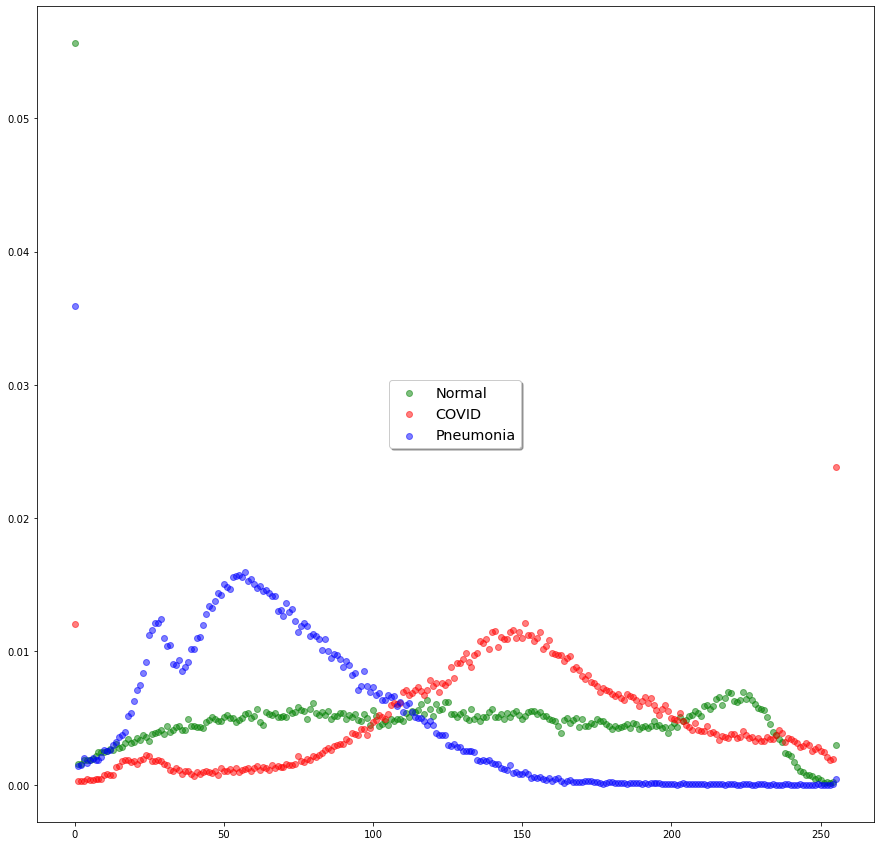

In [51]:

#! disply the scatter plot of all classes in same graph
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
axs.scatter(range(256), normal_train_vectors[11], alpha=0.5, label='Normal', color='green')
axs.scatter(range(256), covid_train_vectors[11], alpha=0.5, label='COVID', color='red')
axs.scatter(range(256), pneumonia_train_vectors[11], alpha=0.5, label='Pneumonia', color='blue')
axs.legend(loc='center',shadow=True, fontsize='x-large')
plt.show()


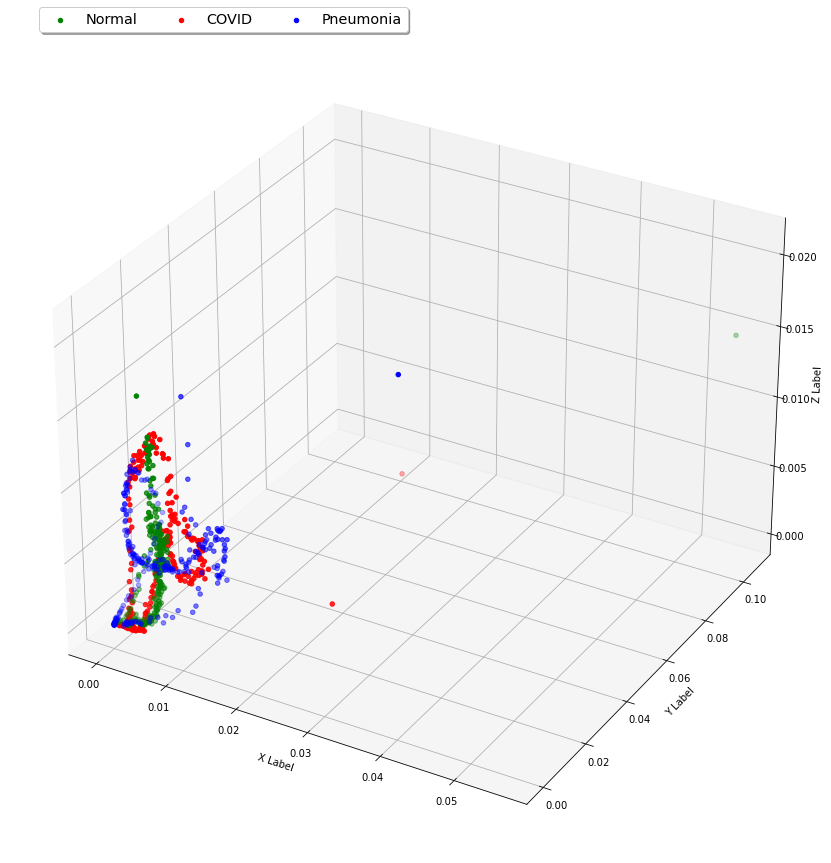

In [52]:
# display the vectors in 3D dimensional space
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normal_train_vectors[11], normal_train_vectors[12], normal_train_vectors[13], marker="o", label='Normal', color='green')
ax.scatter(covid_train_vectors[11], covid_train_vectors[12], covid_train_vectors[13], marker='o', label='COVID', color='red')
ax.scatter(pneumonia_train_vectors[11], pneumonia_train_vectors[12], pneumonia_train_vectors[13], marker='o', label='Pneumonia', color='blue')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(shadow=True, fontsize='x-large', numpoints=1, bbox_to_anchor=(0.5, 1.05), ncol=3)
plt.show()


----

### Clustering 

    - Clustering the vectors that are within the threshold distance(r) for each class
    - The distances are calculated using euclidean distance
    - Each cluster represents a prototype of the respective class
    - This process is done in ./code.ipynb and saved in txt file
    - Now, loading the clusters

In [112]:
normal_clusters = loadFile('./normal_clusters_r_0.025.txt')


# print the clusters
sum=0
for i in range(0, len(normal_clusters)):
    print("Normal Cluster -", i+1, " : ", len(normal_clusters[i]))
    sum+=len(normal_clusters[i])
print("Total number of vectors: ", sum)

Normal Cluster - 1  :  1
Normal Cluster - 2  :  6
Normal Cluster - 3  :  36
Normal Cluster - 4  :  399
Normal Cluster - 5  :  46
Normal Cluster - 6  :  51
Normal Cluster - 7  :  227
Normal Cluster - 8  :  2
Normal Cluster - 9  :  20
Normal Cluster - 10  :  18
Normal Cluster - 11  :  239
Normal Cluster - 12  :  117
Normal Cluster - 13  :  34
Normal Cluster - 14  :  1
Normal Cluster - 15  :  50
Normal Cluster - 16  :  24
Normal Cluster - 17  :  26
Normal Cluster - 18  :  3
Normal Cluster - 19  :  3
Normal Cluster - 20  :  47
Normal Cluster - 21  :  1
Normal Cluster - 22  :  43
Normal Cluster - 23  :  27
Normal Cluster - 24  :  1
Normal Cluster - 25  :  189
Normal Cluster - 26  :  41
Normal Cluster - 27  :  3
Normal Cluster - 28  :  2
Normal Cluster - 29  :  10
Normal Cluster - 30  :  49
Normal Cluster - 31  :  5
Normal Cluster - 32  :  2
Normal Cluster - 33  :  159
Normal Cluster - 34  :  128
Normal Cluster - 35  :  14
Normal Cluster - 36  :  59
Normal Cluster - 37  :  65
Normal Cluster 

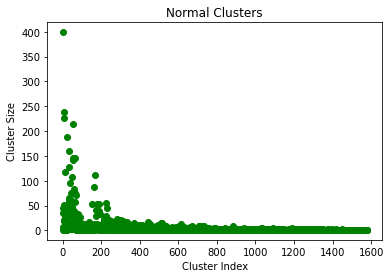

In [113]:
#  plot graph to show cluster index vs cluster size of normal clusters

for i in range(0, len(normal_clusters)):
    plt.scatter(i, len(normal_clusters[i]), color='green')

plt.title('Normal Clusters')
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.show()


In [114]:
covid_clusters = loadFile('./covid_clusters_r_0.019.txt')

sum = 0
for i in range(0, len(covid_clusters)):
    print("COVID Cluster -", i+1, " : ", len(covid_clusters[i]))
    sum+=len(covid_clusters[i])
print("Total number of vectors: ", sum)

COVID Cluster - 1  :  3
COVID Cluster - 2  :  9
COVID Cluster - 3  :  1
COVID Cluster - 4  :  1
COVID Cluster - 5  :  2
COVID Cluster - 6  :  7
COVID Cluster - 7  :  6
COVID Cluster - 8  :  2
COVID Cluster - 9  :  1
COVID Cluster - 10  :  3
COVID Cluster - 11  :  30
COVID Cluster - 12  :  1
COVID Cluster - 13  :  1
COVID Cluster - 14  :  20
COVID Cluster - 15  :  1
COVID Cluster - 16  :  2
COVID Cluster - 17  :  2
COVID Cluster - 18  :  1
COVID Cluster - 19  :  6
COVID Cluster - 20  :  1
COVID Cluster - 21  :  4
COVID Cluster - 22  :  3
COVID Cluster - 23  :  1
COVID Cluster - 24  :  4
COVID Cluster - 25  :  2
COVID Cluster - 26  :  1
COVID Cluster - 27  :  3
COVID Cluster - 28  :  1
COVID Cluster - 29  :  18
COVID Cluster - 30  :  2
COVID Cluster - 31  :  1
COVID Cluster - 32  :  3
COVID Cluster - 33  :  1
COVID Cluster - 34  :  1
COVID Cluster - 35  :  1
COVID Cluster - 36  :  2
COVID Cluster - 37  :  1
COVID Cluster - 38  :  1
COVID Cluster - 39  :  6
COVID Cluster - 40  :  1
COVID 

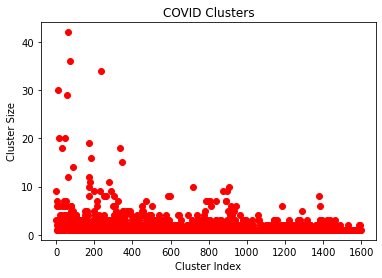

In [115]:

#  plot graph to show cluster index vs cluster size of covid clusters

for i in range(0, len(covid_clusters)):
    plt.scatter(i, len(covid_clusters[i]), color='red')

plt.title('COVID Clusters')
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.show()


In [116]:
pneumonia_clusters = loadFile('./pneumonia_clusters_r_0.015.txt')

sum = 0
for i in range(0, len(pneumonia_clusters)):
    print("Pneumonia Cluster -", i+1, " : ", len(pneumonia_clusters[i]))
    sum+=len(pneumonia_clusters[i])
print("Total number of vectors: ", sum)


Pneumonia Cluster - 1  :  6
Pneumonia Cluster - 2  :  6
Pneumonia Cluster - 3  :  10
Pneumonia Cluster - 4  :  5
Pneumonia Cluster - 5  :  5
Pneumonia Cluster - 6  :  1
Pneumonia Cluster - 7  :  6
Pneumonia Cluster - 8  :  3
Pneumonia Cluster - 9  :  2
Pneumonia Cluster - 10  :  1
Pneumonia Cluster - 11  :  1
Pneumonia Cluster - 12  :  1
Pneumonia Cluster - 13  :  1
Pneumonia Cluster - 14  :  1
Pneumonia Cluster - 15  :  1
Pneumonia Cluster - 16  :  1
Pneumonia Cluster - 17  :  1
Pneumonia Cluster - 18  :  1
Pneumonia Cluster - 19  :  5
Pneumonia Cluster - 20  :  2
Pneumonia Cluster - 21  :  1
Pneumonia Cluster - 22  :  1
Pneumonia Cluster - 23  :  1
Pneumonia Cluster - 24  :  1
Pneumonia Cluster - 25  :  1
Pneumonia Cluster - 26  :  4
Pneumonia Cluster - 27  :  1
Pneumonia Cluster - 28  :  1
Pneumonia Cluster - 29  :  1
Pneumonia Cluster - 30  :  1
Pneumonia Cluster - 31  :  1
Pneumonia Cluster - 32  :  1
Pneumonia Cluster - 33  :  1
Pneumonia Cluster - 34  :  1
Pneumonia Cluster - 35

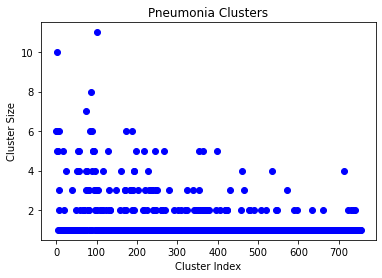

In [117]:

#  plot graph to show cluster index vs cluster size of pneumonia clusters

for i in range(0, len(pneumonia_clusters)):
    plt.scatter(i, len(pneumonia_clusters[i]), color='blue')

plt.title('Pneumonia Clusters')
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.show()

----

### Averaging the clusters

    - Average the vectors in each cluster to get the prototype vector for each class
    - Each average vector will represent the prototype vector for each class
    - This process is done in ./code.ipynb and saved in txt file
    - Now, loading the prototype vectors

In [54]:
normal_prototypes = loadFile('./normal_prototypes_r_0.025.txt')

print("No. of Normal Prototypes: ", len(normal_prototypes))

No. of Normal Prototypes:  1579


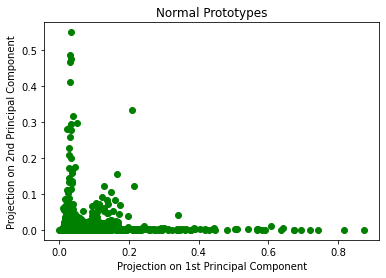

In [55]:
# plot the projections of normal prototypes in 2D space

for i in range(0, len(normal_prototypes)):
    plt.scatter(normal_prototypes[i][0], normal_prototypes[i][1], color='green')

plt.title('Normal Prototypes')
plt.xlabel('Projection on 1st Principal Component')
plt.ylabel('Projection on 2nd Principal Component')
plt.show()

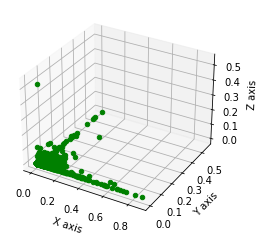

In [56]:
# plot the projections of normal prototypes in 3D space

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0, len(normal_prototypes)):
    ax.scatter(normal_prototypes[i][0], normal_prototypes[i][1], normal_prototypes[i][2], color='green')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [57]:
covid_prototypes = loadFile('./covid_prototypes_r_0.019.txt')

print("No. of COVID Prototypes: ", len(covid_prototypes))


No. of COVID Prototypes:  1597


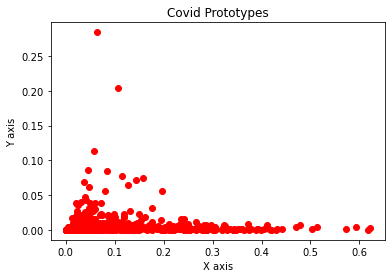

In [58]:
# plot the projections of covid prototypes in 2D space

for i in range(0, len(covid_prototypes)):
    plt.scatter(covid_prototypes[i][0], covid_prototypes[i][1], color='red')

plt.title('Covid Prototypes')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()


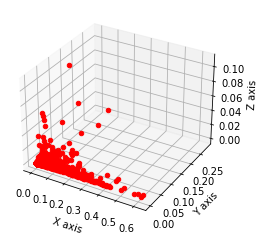

In [59]:
# plot the projections of covid prototypes in 3D space

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0, len(covid_prototypes)):
    ax.scatter(covid_prototypes[i][0], covid_prototypes[i][1], covid_prototypes[i][2], color='red')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()


In [60]:
pneumonia_prototypes = loadFile('./pneumonia_prototypes_r_0.015.txt')

print("No. of Pneumonia Prototypes: ", len(pneumonia_prototypes))

No. of Pneumonia Prototypes:  755


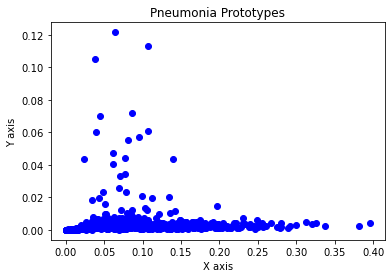

In [61]:
# plot the projections of pneumonia prototypes in 2D space

for i in range(0, len(pneumonia_prototypes)):
    plt.scatter(pneumonia_prototypes[i][0], pneumonia_prototypes[i][1], color='blue')

plt.title('Pneumonia Prototypes')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()

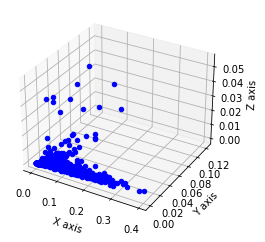

In [62]:
# plot the projections of pneumonia prototypes in 3D space

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0, len(pneumonia_prototypes)):
    ax.scatter(pneumonia_prototypes[i][0], pneumonia_prototypes[i][1], pneumonia_prototypes[i][2], color='blue')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()


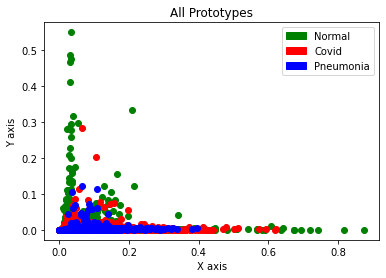

In [63]:
# all prototypes in 2D space

for i in range(0, len(normal_prototypes)):
    plt.scatter(normal_prototypes[i][0], normal_prototypes[i][1], color='green')

for i in range(0, len(covid_prototypes)):
    plt.scatter(covid_prototypes[i][0], covid_prototypes[i][1], color='red')

for i in range(0, len(pneumonia_prototypes)):
    plt.scatter(pneumonia_prototypes[i][0], pneumonia_prototypes[i][1], color='blue')

plt.title('All Prototypes')
plt.xlabel('X axis')
plt.ylabel('Y axis')

green_patch = mpatches.Patch(color='green', label='Normal')
red_patch = mpatches.Patch(color='red', label='Covid')
blue_patch = mpatches.Patch(color='blue', label='Pneumonia')
plt.legend(handles=[green_patch, red_patch, blue_patch])


plt.show()



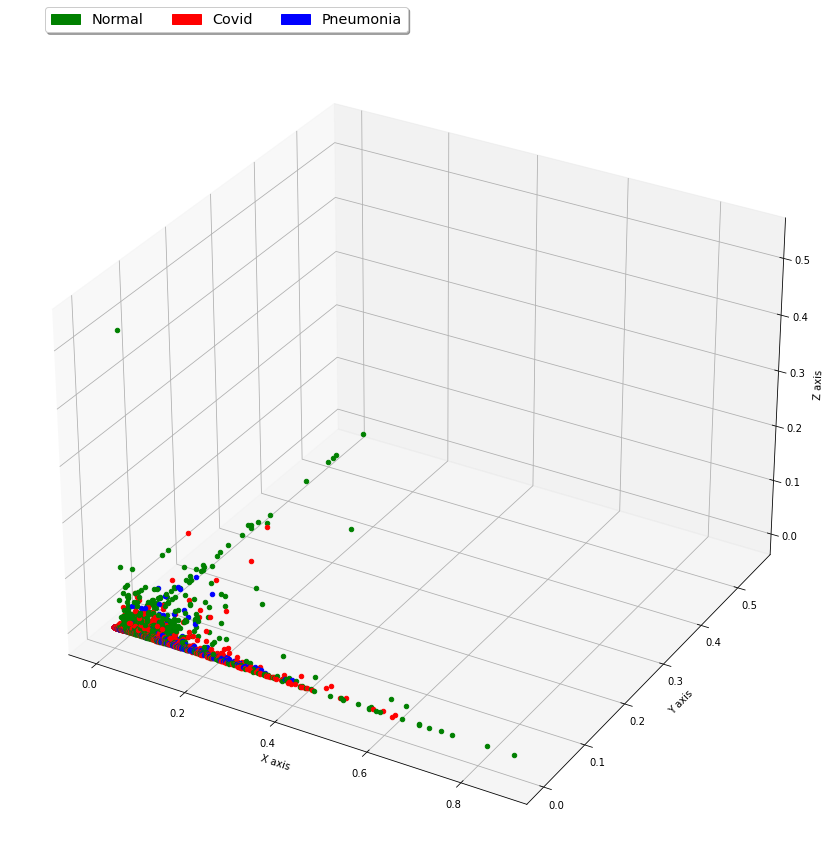

In [64]:
# # display the vectors in 3D dimensional space
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
for i in range(0, len(normal_prototypes)):
    ax.scatter(normal_prototypes[i][0], normal_prototypes[i][1], normal_prototypes[i][2], color='green')

for i in range(0, len(covid_prototypes)):
    ax.scatter(covid_prototypes[i][0], covid_prototypes[i][1], covid_prototypes[i][2], color='red')

for i in range(0, len(pneumonia_prototypes)):
    ax.scatter(pneumonia_prototypes[i][0], pneumonia_prototypes[i][1], pneumonia_prototypes[i][2], color='blue')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

green_patch = mpatches.Patch(color='green', label='Normal')
red_patch = mpatches.Patch(color='red', label='Covid')
blue_patch = mpatches.Patch(color='blue', label='Pneumonia')
plt.legend(handles=[green_patch, red_patch, blue_patch], shadow=True, fontsize='x-large', numpoints=1, bbox_to_anchor=(0.5, 1.05), ncol=3)
plt.show()





----

### Testing the model on test vectors



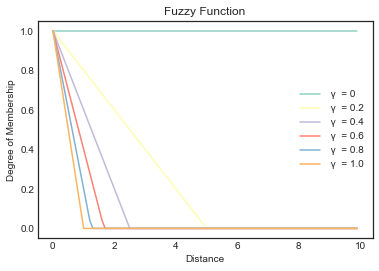

In [194]:
# plotting the graph fuzzy function getDegreeOfMembership

x = np.arange(0, 10, 0.1)


# set of gamma values
gamma = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# plot the graph for each gamma value
for i in range(0, len(gamma)):
    y = []
    for j in range(0, len(x)):
        y.append(getDegreeOfMembership(x[j], gamma[i]))

    plt.plot(x, y, label=' γ  = '+str(gamma[i]))

plt.title('Fuzzy Function')
plt.xlabel('Distance')
plt.ylabel('Degree of Membership')
plt.legend()
plt.show()


    - For each test vector, calculate the distance from each prototype vector
    
    - Assign degree of membership for each prototype vector
    
    - Get the maximum degree of membership and the respective prototype index from each class
    
    - Compare the maximum degrees of membership from each class and assign the class with the maximum degree of membership

In [124]:
# load the test images

covid_test_images_length = len(os.listdir('../COVID-19_Radiography_Dataset/COVID/test_images_sharpen/'))
pneumonia_test_images_length = len(os.listdir('../COVID-19_Radiography_Dataset/Viral Pneumonia/test_images_sharpen/'))
normal_test_images_length = len(os.listdir('../COVID-19_Radiography_Dataset/Normal/test_images_sharpen/'))


# load the test images

covid_test_images = []
pneumonia_test_images = []
normal_test_images = []

for i in range(1, covid_test_images_length+1):
    covid_test_images.append(cv2.imread('../COVID-19_Radiography_Dataset/COVID/test_images_sharpen/COVID-' + str(i) + '.png'))
    
for i in range(1, pneumonia_test_images_length+1):
    pneumonia_test_images.append(cv2.imread('../COVID-19_Radiography_Dataset/Viral Pneumonia/test_images_sharpen/Viral Pneumonia-' + str(i) + '.png'))

for i in range(1, normal_test_images_length+1):
    normal_test_images.append(cv2.imread('../COVID-19_Radiography_Dataset/Normal/test_images_sharpen/Normal-' + str(i) + '.png'))

1. For Covid Image

In [127]:
test_vector = covid_test_vectors[21]

covid_prototype_index, covid_prototype_membership = getMaximumMembership(test_vector, covid_prototypes, 1)
normal_prototype_index, normal_prototype_membership = getMaximumMembership(test_vector, normal_prototypes, 1)
pneumonia_prototype_index, pneumonia_prototype_membership = getMaximumMembership(test_vector, pneumonia_prototypes, 1)

print("\n Class Covid =>","\tPrototype Index: ", covid_prototype_index, "\tPrototype Membership: ", covid_prototype_membership,"\tPercentage: ", covid_prototype_membership*100)
print("\n Class Normal =>","\tPrototype Index: ", normal_prototype_index, "\tPrototype Membership: ", normal_prototype_membership,"\tPercentage: ", normal_prototype_membership*100)
print("\n Class Pneumonia =>","\tPrototype Index: ", pneumonia_prototype_index, "\tPrototype Membership: ", pneumonia_prototype_membership,"\tPercentage: ", pneumonia_prototype_membership*100)


 Class Covid => 	Prototype Index:  809 	Prototype Membership:  0.9873784810462051 	Percentage:  98.73784810462051

 Class Normal => 	Prototype Index:  14 	Prototype Membership:  0.9847169593733922 	Percentage:  98.47169593733922

 Class Pneumonia => 	Prototype Index:  404 	Prototype Membership:  0.9812886595713959 	Percentage:  98.1288659571396


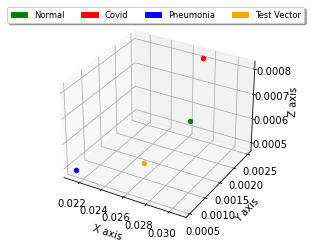

In [128]:
# plot test vector along with all prototypes in 3D space

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(covid_prototypes[covid_prototype_index][0], covid_prototypes[covid_prototype_index][1], covid_prototypes[covid_prototype_index][2], color='red')
ax.scatter(normal_prototypes[normal_prototype_index][0], normal_prototypes[normal_prototype_index][1], normal_prototypes[normal_prototype_index][2], color='green')
ax.scatter(pneumonia_prototypes[pneumonia_prototype_index][0], pneumonia_prototypes[pneumonia_prototype_index][1], pneumonia_prototypes[pneumonia_prototype_index][2], color='blue')

ax.scatter(test_vector[0], test_vector[1], test_vector[2], color='orange')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

green_patch = mpatches.Patch(color='green', label='Normal')
red_patch = mpatches.Patch(color='red', label='Covid')
blue_patch = mpatches.Patch(color='blue', label='Pneumonia')
black_patch = mpatches.Patch(color='orange', label='Test Vector')

plt.legend(handles=[green_patch, red_patch, blue_patch, black_patch], shadow=True, fontsize='small', numpoints=1, bbox_to_anchor=(1.2, 1.05), ncol=4)

plt.show()

Assigned Class:  covid


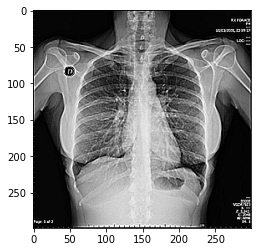

In [129]:
assigned_class = assignClass(covid_prototype_membership, normal_prototype_membership, pneumonia_prototype_membership)
print("Assigned Class: ", assigned_class)

# plot the test image

plt.imshow(covid_test_images[21])
plt.show()


2. For Normal Image

In [134]:
test_vector = normal_test_vectors[20]

covid_prototype_index, covid_prototype_membership = getMaximumMembership(test_vector, covid_prototypes, 1)
normal_prototype_index, normal_prototype_membership = getMaximumMembership(test_vector, normal_prototypes, 1)
pneumonia_prototype_index, pneumonia_prototype_membership = getMaximumMembership(test_vector, pneumonia_prototypes, 1)

print("\n Class Covid =>","\tPrototype Index: ", covid_prototype_index, "\tPrototype Membership: ", covid_prototype_membership,"\tPercentage: ", covid_prototype_membership*100)
print("\n Class Normal =>","\tPrototype Index: ", normal_prototype_index, "\tPrototype Membership: ", normal_prototype_membership,"\tPercentage: ", normal_prototype_membership*100)
print("\n Class Pneumonia =>","\tPrototype Index: ", pneumonia_prototype_index, "\tPrototype Membership: ", pneumonia_prototype_membership,"\tPercentage: ", pneumonia_prototype_membership*100)


 Class Covid => 	Prototype Index:  107 	Prototype Membership:  0.9795276924304002 	Percentage:  97.95276924304002

 Class Normal => 	Prototype Index:  926 	Prototype Membership:  0.9803497864255935 	Percentage:  98.03497864255934

 Class Pneumonia => 	Prototype Index:  521 	Prototype Membership:  0.9758648124583029 	Percentage:  97.5864812458303


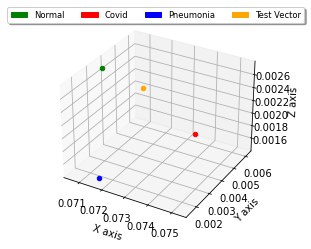

In [135]:
# plot test vector along with all prototypes in 3D space

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(covid_prototypes[covid_prototype_index][0], covid_prototypes[covid_prototype_index][1], covid_prototypes[covid_prototype_index][2], color='red')
ax.scatter(normal_prototypes[normal_prototype_index][0], normal_prototypes[normal_prototype_index][1], normal_prototypes[normal_prototype_index][2], color='green')
ax.scatter(pneumonia_prototypes[pneumonia_prototype_index][0], pneumonia_prototypes[pneumonia_prototype_index][1], pneumonia_prototypes[pneumonia_prototype_index][2], color='blue')

ax.scatter(test_vector[0], test_vector[1], test_vector[2], color='orange')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

green_patch = mpatches.Patch(color='green', label='Normal')
red_patch = mpatches.Patch(color='red', label='Covid')
blue_patch = mpatches.Patch(color='blue', label='Pneumonia')
black_patch = mpatches.Patch(color='orange', label='Test Vector')

plt.legend(handles=[green_patch, red_patch, blue_patch, black_patch], shadow=True, fontsize='small', numpoints=1, bbox_to_anchor=(1.2, 1.05), ncol=4)

plt.show()

Assigned Class:  normal


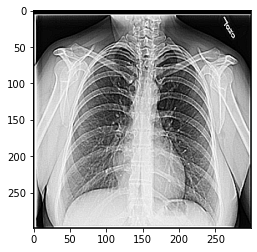

In [136]:
assigned_class = assignClass(covid_prototype_membership, normal_prototype_membership, pneumonia_prototype_membership)
print("Assigned Class: ", assigned_class)

# plot the test image

plt.imshow(normal_test_images[20])
plt.show()


3. For Pneumonia Image

In [137]:
test_vector = pneumonia_test_vectors[20]

covid_prototype_index, covid_prototype_membership = getMaximumMembership(test_vector, covid_prototypes, 1)
normal_prototype_index, normal_prototype_membership = getMaximumMembership(test_vector, normal_prototypes, 1)
pneumonia_prototype_index, pneumonia_prototype_membership = getMaximumMembership(test_vector, pneumonia_prototypes, 1)

print("\n Class Covid =>","\tPrototype Index: ", covid_prototype_index, "\tPrototype Membership: ", covid_prototype_membership,"\tPercentage: ", covid_prototype_membership*100)
print("\n Class Normal =>","\tPrototype Index: ", normal_prototype_index, "\tPrototype Membership: ", normal_prototype_membership,"\tPercentage: ", normal_prototype_membership*100)
print("\n Class Pneumonia =>","\tPrototype Index: ", pneumonia_prototype_index, "\tPrototype Membership: ", pneumonia_prototype_membership,"\tPercentage: ", pneumonia_prototype_membership*100)


 Class Covid => 	Prototype Index:  1393 	Prototype Membership:  0.9755927434709831 	Percentage:  97.55927434709831

 Class Normal => 	Prototype Index:  1033 	Prototype Membership:  0.9810422391528142 	Percentage:  98.10422391528142

 Class Pneumonia => 	Prototype Index:  749 	Prototype Membership:  0.9880049036939155 	Percentage:  98.80049036939155


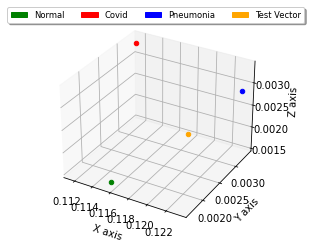

In [138]:
# plot test vector along with all prototypes in 3D space

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(covid_prototypes[covid_prototype_index][0], covid_prototypes[covid_prototype_index][1], covid_prototypes[covid_prototype_index][2], color='red')
ax.scatter(normal_prototypes[normal_prototype_index][0], normal_prototypes[normal_prototype_index][1], normal_prototypes[normal_prototype_index][2], color='green')
ax.scatter(pneumonia_prototypes[pneumonia_prototype_index][0], pneumonia_prototypes[pneumonia_prototype_index][1], pneumonia_prototypes[pneumonia_prototype_index][2], color='blue')

ax.scatter(test_vector[0], test_vector[1], test_vector[2], color='orange')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

green_patch = mpatches.Patch(color='green', label='Normal')
red_patch = mpatches.Patch(color='red', label='Covid')
blue_patch = mpatches.Patch(color='blue', label='Pneumonia')
black_patch = mpatches.Patch(color='orange', label='Test Vector')

plt.legend(handles=[green_patch, red_patch, blue_patch, black_patch], shadow=True, fontsize='small', numpoints=1, bbox_to_anchor=(1.2, 1.05), ncol=4)

plt.show()

Assigned Class:  pneumonia


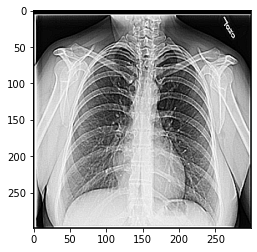

In [139]:
assigned_class = assignClass(covid_prototype_membership, normal_prototype_membership, pneumonia_prototype_membership)
print("Assigned Class: ", assigned_class)

# plot the test image

plt.imshow(normal_test_images[20])
plt.show()


4. For all the test images

In [140]:
y_true = []
y_pred = []

covidCorrectlyClassified = 0
normalCorrectlyClassified = 0
pneumoniaCorrectlyClassified = 0
gamma = 0.1

for i in range(0, len(covid_test_vectors)):
    y_true.append("covid")
    test_vector = covid_test_vectors[i]
    covid_prototype_index, covid_prototype_membership = getMaximumMembership(test_vector, covid_prototypes, gamma)
    normal_prototype_index, normal_prototype_membership = getMaximumMembership(test_vector, normal_prototypes, gamma)
    pneumonia_prototype_index, pneumonia_prototype_membership = getMaximumMembership(test_vector, pneumonia_prototypes, gamma)
    assigned_class = assignClass(covid_prototype_membership, normal_prototype_membership, pneumonia_prototype_membership)
    if assigned_class == "covid":
        covidCorrectlyClassified += 1
        y_pred.append("covid")
    elif assigned_class == "normal":
        y_pred.append("normal")
    elif assigned_class == "pneumonia":
        y_pred.append("pneumonia")
        

for i in range(0, len(normal_test_vectors)):
    y_true.append("normal")
    test_vector = normal_test_vectors[i]
    covid_prototype_index, covid_prototype_membership = getMaximumMembership(test_vector, covid_prototypes, gamma)
    normal_prototype_index, normal_prototype_membership = getMaximumMembership(test_vector, normal_prototypes, gamma)
    pneumonia_prototype_index, pneumonia_prototype_membership = getMaximumMembership(test_vector, pneumonia_prototypes, gamma)
    assigned_class = assignClass(covid_prototype_membership, normal_prototype_membership, pneumonia_prototype_membership)
    if assigned_class == "normal":
        normalCorrectlyClassified += 1
        y_pred.append("normal")
    elif assigned_class == "covid":
        y_pred.append("covid")
    elif assigned_class == "pneumonia":
        y_pred.append("pneumonia")

for i in range(0, len(pneumonia_test_vectors)):
    y_true.append("pneumonia")
    test_vector = pneumonia_test_vectors[i]
    covid_prototype_index, covid_prototype_membership = getMaximumMembership(test_vector, covid_prototypes, gamma)
    normal_prototype_index, normal_prototype_membership = getMaximumMembership(test_vector, normal_prototypes, gamma)
    pneumonia_prototype_index, pneumonia_prototype_membership = getMaximumMembership(test_vector, pneumonia_prototypes, gamma)
    assigned_class = assignClass(covid_prototype_membership, normal_prototype_membership, pneumonia_prototype_membership)
    if assigned_class == "pneumonia":
        pneumoniaCorrectlyClassified += 1
        y_pred.append("pneumonia")
    elif assigned_class == "covid":
        y_pred.append("covid")
    elif assigned_class == "normal":
        y_pred.append("normal")


In [196]:
covidAccuracy = accuracy(len(covid_test_vectors), covidCorrectlyClassified)
normalAccuracy = accuracy(len(normal_test_vectors), normalCorrectlyClassified)
pneumoniaAccuracy = accuracy(
    len(pneumonia_test_vectors), pneumoniaCorrectlyClassified)


totalTestImages = len(pneumonia_test_vectors) + \
    len(covid_test_vectors) + len(normal_test_vectors)
correctlyClassifiedImages = pneumoniaCorrectlyClassified + \
    covidCorrectlyClassified + normalCorrectlyClassified

accuracyOfModel = accuracy(totalTestImages, correctlyClassifiedImages)

totalTrainingImages = len(pneumonia_train_vectors) + \
    len(covid_train_vectors) + len(normal_train_vectors)

totalImages = totalTrainingImages + totalTestImages

print("\n\nTotal images:\t\t\t\t", totalImages)
print("\n\tNormal:\t\t",  len(normal_train_vectors) + len(normal_test_vectors))
print("\tCovid:\t\t",  len(covid_train_vectors) + len(covid_test_vectors))
print("\tPneumonia:\t\t",  len(pneumonia_train_vectors) +
      len(pneumonia_test_vectors))


print("\nTotal training images:\t\t", totalTrainingImages)
print("\n\tNormal:\t\t",  len(normal_train_vectors))
print("\tCovid:\t\t",  len(covid_train_vectors))
print("\tPneumonia:\t",  len(pneumonia_train_vectors))

print("\nTotal test images:\t\t\t", totalTestImages)
print("\n\tNormal:\t\t",  len(normal_test_vectors))
print("\tCovid:\t\t",  len(covid_test_vectors))
print("\tPneumonia:\t",  len(pneumonia_test_vectors))


print("\n\nNormal Class:\n")
print("\tNo. of prototypes:\t\t\t", len(normal_prototypes))
print("\tCorrectly classified:\t\t",
      normalCorrectlyClassified, "/", len(normal_test_vectors))
print("\tIncorrectly classified:\t\t", len(normal_test_vectors) -
      normalCorrectlyClassified, "/", len(normal_test_vectors))
print("\tAccuracy:\t\t\t\t\t", normalAccuracy)

print("\n\nCovid Class:\n")
print("\tNo. of prototypes:\t\t\t", len(covid_prototypes))
print("\tCorrectly classified:\t\t",
      covidCorrectlyClassified, "/", len(covid_test_vectors))
print("\tIncorrectly classified:\t\t", len(covid_test_vectors) -
      covidCorrectlyClassified, "/", len(covid_test_vectors))
print("\tAccuracy:\t\t\t\t\t", covidAccuracy)

print("\n\nPneumonia Class:\n")
print("\tNo. of prototypes:\t\t\t", len(pneumonia_prototypes))
print("\tCorrectly classified:\t\t", pneumoniaCorrectlyClassified,
      "/", len(pneumonia_test_vectors))
print("\tIncorrectly classified:\t\t", len(pneumonia_test_vectors) -
      pneumoniaCorrectlyClassified, "/", len(pneumonia_test_vectors))
print("\tAccuracy:\t\t\t\t\t", pneumoniaAccuracy)


print("\n\nTotal Correctly Classified Images:\t\t",
      correctlyClassifiedImages, "/", totalTestImages)
print("\nAccuracy of Model:\t\t\t\t\t\t", accuracyOfModel)




Total images:				 15153

	Normal:		 10192
	Covid:		 3616
	Pneumonia:		 1345

Total training images:		 12121

	Normal:		 8153
	Covid:		 2892
	Pneumonia:	 1076

Total test images:			 3032

	Normal:		 2039
	Covid:		 724
	Pneumonia:	 269


Normal Class:

	No. of prototypes:			 1579
	Correctly classified:		 1700 / 2039
	Incorrectly classified:		 339 / 2039
	Accuracy:					 83.37420304070623


Covid Class:

	No. of prototypes:			 1597
	Correctly classified:		 519 / 724
	Incorrectly classified:		 205 / 724
	Accuracy:					 71.68508287292818


Pneumonia Class:

	No. of prototypes:			 755
	Correctly classified:		 201 / 269
	Incorrectly classified:		 68 / 269
	Accuracy:					 74.72118959107806


Total Correctly Classified Images:		 2420 / 3032

Accuracy of Model:						 79.81530343007915


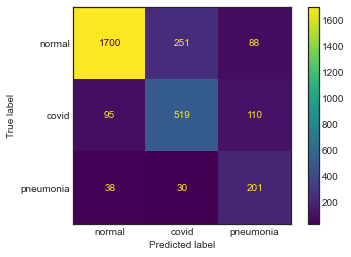

In [200]:
# get the confusion matrix with class labels
cm = confusion_matrix(y_true, y_pred, labels=["normal", "covid", "pneumonia"])
# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "covid", "pneumonia"])
disp.plot()
plt.show()



In [143]:
# get the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       covid       0.65      0.72      0.68       724
      normal       0.93      0.83      0.88      2039
   pneumonia       0.50      0.75      0.60       269

    accuracy                           0.80      3032
   macro avg       0.69      0.77      0.72      3032
weighted avg       0.82      0.80      0.81      3032



In [110]:
# get the statistical analysis
print("Statistical Analysis")

Statistical Analysis
